In [2]:
import sys
import os.path
from pathlib import Path
import numpy as np #has own array 1D, 2D, 3D
import pandas as pd #for table programme
%matplotlib inline
import matplotlib.pyplot as plt #for basic plots also in 3D
import seaborn as sns #fancy graphs
from numpy.polynomial.polynomial import polyfit
import math
import glob

###############################################################################
############################    DATA PREPARATION     ##########################
###############################################################################
# use the golddigger imageJ plugin on an image. 
#http://www.nanotomy.org/OA/Sjollema2016MI/thumbs/GolddiggerManual-20160613.pdf
# use on a bin image, shrink factor 4, average.
# somehow there's a bug when first drawing the coordinate line in an image,
# so do golddigger first followed by drawing the line per image.
# may have to adjust the contrast of the image before picking particles.
# draw line from a striation between two tufts of material, pick the same 
# striation for each rootlet 
# ROI, properties/list-coordinates, save
###############################################################################

repeat = 36.5482 #This should be measured in the image
striation= 79.485
factor = striation/repeat #multiply by factor to get nm

##temporary:
file_name = "root1_bin4_results.csv"
angle_name = "root1_bin4_results_coordinates.csv"

#file_name = "0001_bin4_results.csv"
#angle_name = "0001_bin4_coordinates.csv"

#start a loop through modules  
def readtables(file_name, angle_name):    # read the tables
    global df
    df = pd.DataFrame()
    global adf
    adf = pd.DataFrame()
    df = pd.read_csv(file_name, engine='python')
    df['YM'] = df['YM']*-1 + 1024   
#to flip the y-axis to the same orientation as the image with size 1024
    adf = pd.read_csv(angle_name, engine='python')
    adf['Y'] = adf['Y']*-1 + 1024
#if you have images where the drawn line isn't ascending positively, 
#you need to flip the data and line.
    if adf.loc[0,'X'] > adf.loc[1,'X']:
        df['XM'] = df['XM']*-1 + 1024
        adf['X'] = adf['X']*-1 + 1024
    if adf.loc[0,'Y'] > adf.loc[1,'Y']:
        df['YM'] = df['YM']*-1 + 1024
        adf['Y'] = adf['Y']*-1 + 1024

          Area      XM       YM  Perim.  xintersect       yold       ynew  \
0      1     7  458.21     2.50    9.07  475.192081  16.982081  15.910948   
1      2     6  417.67     2.67    8.49  475.255501  57.585501  53.953335   
2      3    11  470.50     7.50   12.49  477.057376   6.557376   6.143774   
3      4     7  433.64     7.21    9.07  476.949189  43.309189  40.577492   
4      5     8  538.62     8.38    9.07  477.385668 -61.234332 -57.372018   
..   ...   ...     ...      ...     ...         ...        ...        ...   
874  875     9  909.06  1018.83   10.49  854.343215 -54.716785 -51.265562   
875  876     7  882.50  1018.21    9.07  854.111918 -28.388082 -26.597523   
876  877     8  804.75  1018.75   10.49  854.313370  49.563370  46.437194   
877  878     7  863.21  1020.50    9.07  854.966223  -8.243777  -7.723806   
878  879     8  834.62  1021.38    9.07  855.294515  20.674515  19.370484   

          newori   yintersect        xold       sqxnew2       xnew2  \
0   

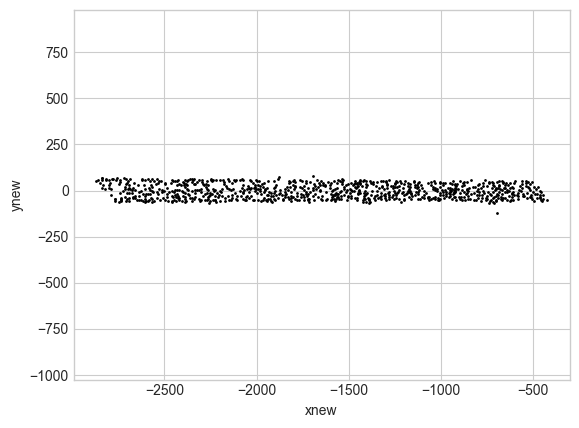

In [3]:
###############################################################################
#####fit through points isn't through the center of mass of points#############
###############################################################################
#b, m = polyfit(df['XM'],df['YM'], 1)
#plt.plot(df['XM'], b + m * df['XM'], '-')
#plt.show()
###############################################################################

def rotate(adf, df):
    #calculate angle of the drawn line
    dydx = (adf.at[0,'Y'] - adf.at[1,'Y'])/(adf.at[0,'X'] - adf.at[1,'X'])
    alpha = math.atan(dydx)
    
    #where the fiducial y value matches the y value of the line
    df['xintersect'] = (df['YM'] - (adf.at[0,'Y'] - \
        (dydx * adf.at[0,'X']))) / dydx  
    df['yold'] = df['xintersect'] - df['XM'] 
    #the new y coordinate, with the line as new x-axis
    df['ynew'] = math.sin(alpha)*df['yold']  
 
    ###########################################################################
    ####to be able to add multiple measurements################################
    ###########################################################################
    #I started each coordinate line on the same striation feature. 
    #Use this as the origin of the new X-axis
    df['newori'] = (adf.at[0,'X'] / math.cos(alpha))
    
    #new X coordinate
    df['yintersect'] = (dydx * df['XM']) + (adf.at[0,'Y'] - 
        (dydx * adf.at[0,'X']))   
    df['xold'] = df['YM'] - df['yintersect'] 
    
    #xnew2 is distance between y-intersect and new x-coordinate
    df['sqxnew2'] = df['xold']*df['xold'] - df['ynew']*df['ynew']
    sqxnew2 = pd.Series(df['sqxnew2'])  
    df['xnew2'] = np.sqrt(sqxnew2)  
    #sqrt function has to be provided as an array rather than a column
    #xnew1=distance between origin and y-intersect
    df['xnew1'] = df['yintersect']/math.sin(alpha) 
    
    # if yold is negative, then xnew = xnew1 -xnew2 else xnew = xnew1+xnew2 
    # this is needed because some points are below the line that was drawn
    # df['posneg'] = df ['yold']
    df.loc[df.yold < 0, "posneg"] = df['xnew2']*-1
    df.loc[df.yold >= 0, "posneg"] = df['xnew2']

    ###########################################################################
    #adjusted now for new origin for multiple measurements#####################
    ###########################################################################
    # xnew is the distance between 1) where the drawn line intersects the 
    # old x-axis, and 2) the new x-coordinate    
    df['xnew'] = (df['xnew1']+df['posneg']-df['newori'])*factor
    
    #column for the new y-value, this is to later 1-dimensionalize the data.
    df.at[:,'ynull'] = 0
    
    


##loop through the files in the folder
#finaldf = pd.DataFrame()
#for i in glob.glob("*_bin4_coordinates.csv"): 
#    file_name = i[0:4] + "_bin4_results.csv"  
#    readtables(file_name, i)
#    rotate(adf, df)
#    #concatenate the different files to run an analysis as a whole later
#    finaldf = pd.concat([finaldf, df], ignore_index=True) 

#temporary for only a single file
readtables(file_name, angle_name)
rotate(adf, df)
finaldf = df.copy()

#plot
plt.style.use('seaborn-v0_8-whitegrid')
finaldf.plot.scatter(x='xnew',y='ynew',s=1, c="black") # scatter plot
plt.axis('equal')
plt.draw()

print(finaldf) #for total number of fiducials

In [4]:
###############################################################################
# 1-dimensionalize, collapse Y axis. ##########################################
###############################################################################
# fit a distribution on a 1d axis
# shift everything to positive with increments the same to the repeat length
min_value = finaldf['xnew'].min()

#how much data is below 0, expressed in repeat length
howmany = math.ceil(min_value*-1/striation)
shiftlen = howmany * striation
#define a new 0
finaldf['newzero'] = (finaldf['xnew'] + shiftlen) 

dataa = finaldf['newzero']
#plot a single histogram for particles of all rootlets 
#sns.displot(dataa, bw_adjust=0.25/striation, kind="kde")
#sns.kdeplot(x=finaldf.newzero, y=finaldf.ynew, cmap="Reds", 
#shade=True, bw_adjust=.5)


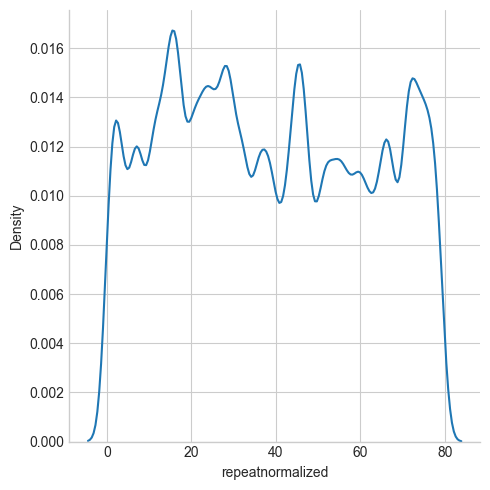

In [5]:
###############################################################################
# combine all the particles of each repeat and display on a single repeat #####
###############################################################################

finaldf['repeatnormalized'] = finaldf['newzero']
max_value = finaldf['repeatnormalized'].max()

while max_value > striation:
    if max_value < striation: break
    else:
        finaldf.loc[finaldf.repeatnormalized > striation, "repeatnormalized"] \
            = finaldf['repeatnormalized']-striation
        max_value = finaldf['repeatnormalized'].max()

data = finaldf['repeatnormalized']
sns.displot(data, bw_adjust=0.25, kind="kde")
plt.show()

#plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [7]:
###############################################################################
# combine all the particles of three repeats, with iterative steps ############
# and display on three repeats. This should give the 2nd repeat a  ############
# pattern that is unbiased by the edges of the data                ############
###############################################################################

finaldf['threerepeat'] = finaldf['newzero']
#finaldf['threerepeat'] = finaldf['xnew'] #won't work because I divide later by 
#the repeat while positive.

#print(df)
max_value = finaldf['threerepeat'].max()
norm_df = pd.DataFrame(None)
#norm_df = pd.DataFrame()
#add_df = pd.DataFrame(None)
#add_df = pd.DataFrame()
x = 0
while max_value > 3*striation:
    while x != 2:
        finaldf.loc[finaldf.threerepeat >= 0, "threerepeat"] = \
            finaldf['threerepeat']-striation
        max_value = finaldf['threerepeat'].max()
        x += 1
    else:
        if max_value < 3*striation: break
        else:
            add_df = pd.DataFrame(None)
        #add_df = df[(0 <= df['threerepeat'] < 3*repeat)]
            add_df = finaldf[(finaldf['threerepeat'] < 3*striation) & \
                (finaldf['threerepeat'] >= 0)]              
            norm_df = pd.concat([norm_df, add_df], ignore_index=True) 
        #norm_df = df[0 < dataframe['threerepeat'] > 3*repeat]
        #rslt_df = dataframe.loc[dataframe['Percentage'] > 80]
        #rslt_df = dataframe.loc[dataframe['Percentage'] != 95]
            finaldf.loc[finaldf.threerepeat >= 0, "threerepeat"] = \
                finaldf['threerepeat']-striation
            max_value = finaldf['threerepeat'].max()

#print(norm_df)
data = norm_df['threerepeat']


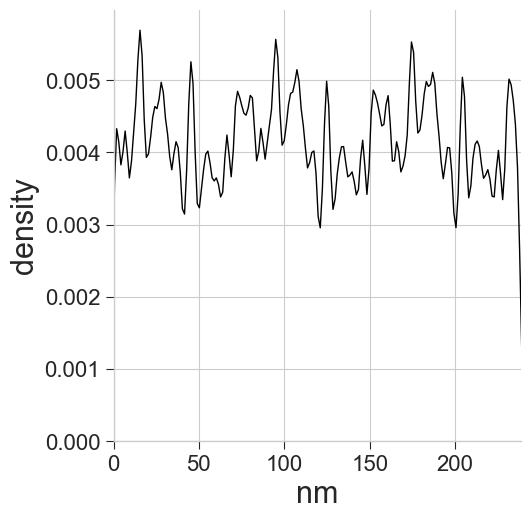

In [8]:
###############################################################################
# plot line ###################################################################
###############################################################################

sns.displot(data, bw_adjust=0.1, kind="kde", color='black', linewidth=1)
#plt.style.use('seaborn-white')
plt.xlabel('nm', fontsize=22)
plt.ylabel('density', fontsize=22)
plt.tick_params(axis='both', direction='out', length=6, which='major', 
    labelsize=16)
plt.xlim(0, 3*striation)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'ccdc102b_single.svg'

plt.savefig(image_name, format=image_format)



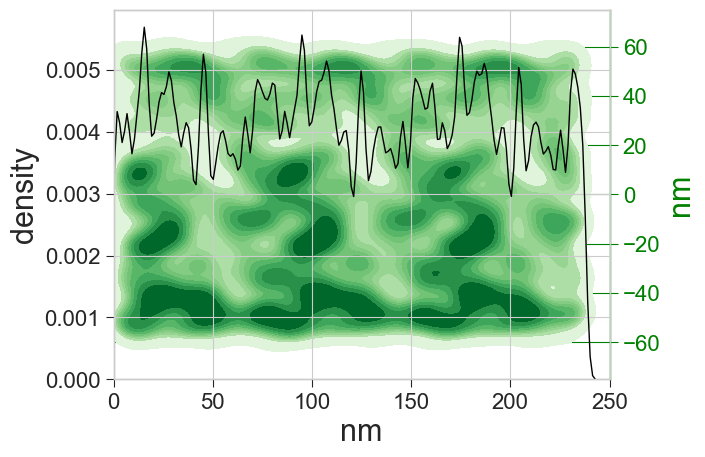

In [73]:
###############################################################################
# plot line and spatial distribution behind it for final figure ###############
###############################################################################

displayrange = 3*striation

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#plotgreen heatmap
sns.kdeplot(x=norm_df.threerepeat, y=norm_df.ynew, ax=ax2, cmap="Greens", \
    fill=True, bw_adjust=.4, zorder=1, )
ax2.set_xlabel('nm', fontsize=22)
ax2.set_ylabel('nm', fontsize=22, color='green')
ax2.set_zorder(1)
ax2.tick_params(axis='y', direction='out', length=6, which='major', \
                labelsize=16, color='green', labelcolor='green', grid_color='green')
ax2.spines['right'].set_color('green')

#plot histogram
sns.kdeplot(data, bw_adjust=0.1, ax=ax1, color='black', linewidth=1, zorder=2)
ax1.set_ylabel('density', fontsize=22)
ax1.set_zorder(2)
ax1.set_facecolor('none')
ax1.tick_params(axis='both', direction='out', length=6, which='major', \
    labelsize=16)
ax1.set_xlabel('nm', fontsize=22)

plt.xlim(0, displayrange)
plt.ylim(-75, 75)
plt.xlabel('nm', fontsize=22)
#plt.tick_params(axis='both', direction='out', length=6, which='major', \
#    labelsize=16)
plt.xticks(ticks=(0,50,100,150,200,250))
fig.set_edgecolor("green")

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'ccdc102b_combined.svg'
plt.savefig(image_name, format=image_format)
